## Intro

Hi, I'm a current high school student in Ottawa, Ontario, Canada. I started studying machine learning last year, and I first ran into neural network at the beginning of this year. I first used RNN to predict the trends of the stock market, but there is no luck yet. So if you seen anything I did wrong or misinterpreted anything, please don't hesitate to point them out.

I joined this research competition in September. At first I thought I was going to classify different drugs, but after some extra researches, I discover the purpose of this research is to predict a drug's effect in human cells(the predictions are in percentages). At first I also thought the score is accuracy of prediction, only later I discovered my stupidity by realizing the score is calculate using log loss.

During September, I first implemented random forest classifier, and only took the top 20 features with the highest corrolation for each MoA into the process of training. The score wasn't good, about 0.10115 in log loss. 

Then I saw others using neural network so I decided to build my own. I first used Sequential TensorFlow to build my model and I improved my socre to 0.01891 in log loss. 

After that, I saw [Mechanisms of Action (MoA) Tutorial by Sina MhD](https://https://www.kaggle.com/sinamhd9/mechanisms-of-action-moa-tutorial/comments)
and realized that only using one network and over-emphasizing the sophistication and the complexity of a single network may lead to over-fitting. So I started averaging out the results of different networks. This brought my score to 0.01869. And my current algorithm also inherited this idea with the exception of using ratios rather than simply taking the average. 

During November, I learned Pytorch, going from Tensorflow to Pytorch was a leap for me. This reminds me the time I went from using the language of Quantpian to Backtrader library in python. 

And I also discovered that QuantileTransformer is much more maneuverable than MinMaxScale is this case, since MinMaxScale transforms negative data into values between 0 and 0.005, but QuantileTransformer doesn't seem to have this problem with negative values. Also I discovered VarianceThreshold, which can be used to mow out the less relevent data. 

After the competition ended, I also used Gauss Rank to normalize the data. This also improved my score by 0.00002. 

In the rest of notebook, many parts came from [MoA: Pytorch-RankGauss-PCA-NN upgrade & 3D visual](https://https://www.kaggle.com/vbmokin/moa-pytorch-rankgauss-pca-nn-upgrade-3d-visual) by [Prof. Vitalii Mokin](https://https://www.kaggle.com/vbmokin) from Vinnytsia National Technical University. 

## Table of contents <a class="anchor" id="0"></a>


### [1. Import libraries](#1)

### [2. Download data](#2)

### [3. FE & Data Preprocessing](#3)

*   [3.1 Gauss Rank Data normalization](#3.1)
*   [3.2 Seed](#3.2)
*   [3.3 PCA features](#3.3)
*   [3.4 Feature selection](#3.4)
*   [3.5 CV folds](#3.5)
*   [3.6 Dataset Classes](#3.6)
*   [3.7 Smoothing](#3.7)
*   [3.8 Preprocessing](#3.8)   

### [4. Modeling](#4)

### [5. Submission](#5)




## 1. Import libraries<a class="anchor" id="1"></a>

[Back to Table of Contents](#0)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import sys
sys.path.append('/kaggle/input/iterative-stratification/iterative-stratification-master')

In [ ]:
import sys
#sys.path.append('../input/iterativestratification')

import numpy as np
import random
import pandas as pd
import os
import copy
import gc
from scipy.special import erfinv

import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import VarianceThreshold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.loss import _WeightedLoss

import warnings
warnings.filterwarnings('ignore')

#os.listdir('../input/lish-moa')

pd.set_option('max_columns', 2000)

## 2. Download data<a class="anchor" id="2"></a>

[Back to Table of Contents](#0)

In [ ]:
train_features = pd.read_csv("/kaggle/input/lish-moa/train_features.csv")
train_targets_scored = pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')
#train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')

test_features = pd.read_csv('/kaggle/input/lish-moa/test_features.csv')
sample_submission = pd.read_csv('/kaggle/input/lish-moa/sample_submission.csv')

In [ ]:
n_comp_GENES = int(0.6*610)
n_comp_CELLS = int(0.6*55)
VarianceThreshold_for_FS = 0.82

In [ ]:
train_features

## 3. FE & Data Preprocessing <a class="anchor" id="3"></a>

[Back to Table of Contents](#0)

In [ ]:
GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]

### 3.1 Gauss Rank Data normalization <a class="anchor" id="3.1"></a>

[Back to Table of Contents](#0)

After the competition ended, I saw people saying Gauss Rank is better than QuantileTransformer, so I decided to try on my own, and Gauss Rank did turn out to be better than quantile transformer. Gauss Rank improved my score by 0.00002 and its result is more normally distributed. Maybe it's because QuantileTransformer is non-linear, and it may distorted some linear corrlation within the data (I'm just guessing the reason here, if you know why, please post a comment below, I'll be very thankful for that).

In [ ]:
# RankGauss - transform to Gauss
train_len = len(train_features.values)
test_len = len(test_features.values)

for col in (GENES + CELLS):

    epsilon = 1e-6
    
    
    
    train_1col = train_features[col].values.reshape(train_len, 1)
    test_1col = test_features[col].values.reshape(test_len, 1)

    np_arr_total = np.vstack((train_1col, test_1col))
  
    res = np_arr_total[:,0].argsort().argsort()
    res = (res/res.max()-0.5)*2 
    res = np.clip(res,-1+epsilon,1-epsilon)
    res = erfinv(res) 
    np_arr_total_r = np_arr_total 
    np_arr_total_r[:,0] = res * np.sqrt(2)

    train_features[col] = (np_arr_total_r[:train_len]).reshape(1, train_len)[0]
    test_features[col] = (np_arr_total_r[train_len:]).reshape(1, test_len)[0]

Gauss Rank:
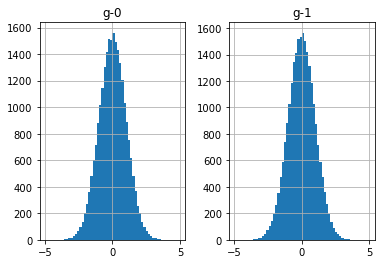


Quantile Transformer:
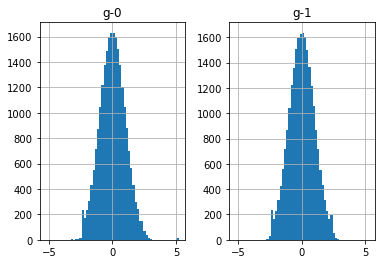
Here is also is visualized comparison between the results of QuantileTransformer and Gauss Rank.

### 3.2 Seed<a class="anchor" id="3.2"></a>

[Back to Table of Contents](#0)

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

### 3.3 PCA features<a class="anchor" id="3.3"></a>

[Back to Table of Contents](#0)

In [ ]:
# GENES

data = pd.concat([pd.DataFrame(train_features[GENES]), pd.DataFrame(test_features[GENES])])
data2 = (PCA(n_components=n_comp_GENES, random_state=42).fit_transform(data[GENES]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_G-{i}' for i in range(n_comp_GENES)])
test2 = pd.DataFrame(test2, columns=[f'pca_G-{i}' for i in range(n_comp_GENES)])

train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

In [ ]:
len(GENES)

In [ ]:
# CELLS

data = pd.concat([pd.DataFrame(train_features[CELLS]), pd.DataFrame(test_features[CELLS])])
data2 = (PCA(n_components=n_comp_CELLS, random_state=42).fit_transform(data[CELLS]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_C-{i}' for i in range(n_comp_CELLS)])
test2 = pd.DataFrame(test2, columns=[f'pca_C-{i}' for i in range(n_comp_CELLS)])

train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

In [ ]:
len(CELLS)

In [ ]:
train_features.shape

In [ ]:
train_features.head(5) 

### 3.4 FS by Variance Encoding<a class="anchor" id="3.4"></a>

[Back to Table of Contents](#0)

VarianceThreshold remove all features with low variances, in this case, lower than 0.82.

In [ ]:
var_thresh = VarianceThreshold(VarianceThreshold_for_FS)
data = train_features.append(test_features)
data_transformed = var_thresh.fit_transform(data.iloc[:, 4:])

train_features_transformed = data_transformed[ : train_features.shape[0]]
test_features_transformed = data_transformed[-test_features.shape[0] : ]


train_features = pd.DataFrame(train_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                              columns=['sig_id','cp_type','cp_time','cp_dose'])

train_features = pd.concat([train_features, pd.DataFrame(train_features_transformed)], axis=1)


test_features = pd.DataFrame(test_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                             columns=['sig_id','cp_type','cp_time','cp_dose'])

test_features = pd.concat([test_features, pd.DataFrame(test_features_transformed)], axis=1)

train_features.shape

In [ ]:
train_features.head(5)

In [ ]:
train = train_features.merge(train_targets_scored, on='sig_id')
train = train[train['cp_type']!='ctl_vehicle'].reset_index(drop=True)
test = test_features[test_features['cp_type']!='ctl_vehicle'].reset_index(drop=True)

target = train[train_targets_scored.columns]

In [ ]:
train = train.drop('cp_type', axis=1)
test = test.drop('cp_type', axis=1)

In [ ]:
train.head(5)

In [ ]:
target_cols = target.drop('sig_id', axis=1).columns.values.tolist()

### 3.5 CV folds<a class="anchor" id="3.5"></a>

[Back to Table of Contents](#0)

In [ ]:
folds = train.copy()

mskf = MultilabelStratifiedKFold(n_splits=7)

for f, (t_idx, v_idx) in enumerate(mskf.split(X=train, y=target)):
    folds.loc[v_idx, 'kfold'] = int(f)

folds['kfold'] = folds['kfold'].astype(int)
folds

In [ ]:
print(train.shape)
print(folds.shape)
print(test.shape)
print(target.shape)
print(sample_submission.shape)

### 3.6 Dataset Classes<a class="anchor" id="3.6"></a>

[Back to Table of Contents](#0)

In [ ]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)            
        }
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct
    

In [ ]:
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
    model.train()
    final_loss = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        final_loss += loss.item()
        
    final_loss /= len(dataloader)
    
    return final_loss


def valid_fn(model, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    valid_preds = []
    
    for data in dataloader:
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        final_loss += loss.item()
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    
    return final_loss, valid_preds

def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)

        with torch.no_grad():
            outputs = model(inputs)
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    
    return preds

### 3.7 Smoothing<a class="anchor" id="3.7"></a>

[Back to Table of Contents](#0)

In [ ]:
class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

### 3.8 Preprocessing<a class="anchor" id="3.8"></a>

[Back to Table of Contents](#0)

In [ ]:
def process_data(data):
    data = pd.get_dummies(data, columns=['cp_time','cp_dose'])
    return data

In [ ]:
feature_cols = [c for c in process_data(folds).columns if c not in target_cols]
feature_cols = [c for c in feature_cols if c not in ['kfold','sig_id']]
len(feature_cols)

## 4. Modeling<a class="anchor" id="4"></a>

[Back to Table of Contents](#0)

In [ ]:
# HyperParameters

DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')    
EPOCHS = 22
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
NFOLDS = 7 #7
EARLY_STOPPING_STEPS = 10
EARLY_STOP = False

num_features=len(feature_cols)
num_targets=len(target_cols)
#hidden_size=1500  

In [ ]:


class Model(nn.Module):
    def recalibrate_layer(self, layer):
      if(torch.isnan(layer.weight_v).sum() > 0):
          layer.weight_v = torch.nn.Parameter(torch.where(torch.isnan(layer.weight_v), torch.zeros_like(layer.weight_v), layer.weight_v))
          layer.weight_v = torch.nn.Parameter(layer.weight_v + 1e-7)

      if(torch.isnan(layer.weight).sum() > 0):
          layer.weight = torch.where(torch.isnan(layer.weight), torch.zeros_like(layer.weight), layer.weight)
          layer.weight += 1e-7

    def __init__(self, num_features, num_targets, hidden_size_1d, dropout_rate_1d):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size_1d[0]))
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size_1d[0])
        self.dropout2 = nn.Dropout(dropout_rate_1d[0])
        self.dense2 = nn.utils.weight_norm(nn.Linear(hidden_size_1d[0], hidden_size_1d[1]))
        
        self.batch_norm3 = nn.BatchNorm1d(hidden_size_1d[1])
        self.dropout3 = nn.Dropout(dropout_rate_1d[1])
        self.dense3 = nn.utils.weight_norm(nn.Linear(hidden_size_1d[1], num_targets))
    
    def forward(self, x):     
        x = self.batch_norm1(x)
        #self.recalibrate_layer(self.dense1)
        x = F.leaky_relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        #self.recalibrate_layer(self.dense2)
        x = F.leaky_relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        #self.recalibrate_layer(self.dense3)
        x = self.dense3(x)
        
        return x
    
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))    


In [ ]:
def run_training(fold, seed, hidden_size, dropout_rate):
    
    seed_everything(seed)
    
    train = process_data(folds)
    test_ = process_data(test)
    
    trn_idx = train[train['kfold'] != fold].index
    val_idx = train[train['kfold'] == fold].index
    
    train_df = train[train['kfold'] != fold].reset_index(drop=True)
    valid_df = train[train['kfold'] == fold].reset_index(drop=True)
    
    x_train, y_train  = train_df[feature_cols].values, train_df[target_cols].values
    x_valid, y_valid =  valid_df[feature_cols].values, valid_df[target_cols].values
    
    train_dataset = MoADataset(x_train, y_train)
    valid_dataset = MoADataset(x_valid, y_valid)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size_1d=hidden_size,
        dropout_rate_1d=dropout_rate,
    )
    
    model.to(DEVICE)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(trainloader))
    
    loss_fn = nn.BCEWithLogitsLoss()
    loss_tr = SmoothBCEwLogits(smoothing =0.001)
    
    early_stopping_steps = EARLY_STOPPING_STEPS
    early_step = 0
   
    oof = np.zeros((len(train), target.iloc[:, 1:].shape[1]))
    best_loss = np.inf
    
    for epoch in range(EPOCHS):
        
        train_loss = train_fn(model, optimizer,scheduler, loss_tr, trainloader, DEVICE)
        print(f"FOLD: {fold}, EPOCH: {epoch}, train_loss: {train_loss}")
        valid_loss, valid_preds = valid_fn(model, loss_fn, validloader, DEVICE)
        print(f"FOLD: {fold}, EPOCH: {epoch}, valid_loss: {valid_loss}")
        
        if valid_loss < best_loss:
            
            best_loss = valid_loss
            oof[val_idx] = valid_preds
            torch.save(model.state_dict(), f"FOLD{fold}_.pth")
        
        elif (EARLY_STOP == True):
            
            early_step += 1
            if (early_step >= early_stopping_steps):
                break
            
    
    #--------------------- PREDICTION---------------------
    x_test = test_[feature_cols].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size_1d=hidden_size,
        dropout_rate_1d=dropout_rate,
    )
    
    model.load_state_dict(torch.load(f"FOLD{fold}_.pth"))
    model.to(DEVICE)
    
    predictions = np.zeros((len(test_), target.iloc[:, 1:].shape[1]))
    predictions = inference_fn(model, testloader, DEVICE)
    
    return oof, predictions

In [ ]:
def run_network(fold, seed, NFOLDS):
    hidden_size_arr = [[1000, 1500], [800, 1400], [1500, 1000], [1500, 1500]]     
    dropout_rate_arr = [[1/6, 0.25], [2/15, 7/30], [0.25, 1/6], [0.25, 0.25]]     
    weight_rate_arr = [[0.3], [0.3], [0.2], [0.2]]
    oof_this_fold = np.zeros((len(train), len(target_cols)))
    predictions_this_fold = np.zeros((len(test), len(target_cols)))
    
    for this_network_i in range(len(hidden_size_arr)):
        print("network:",this_network_i)
        oof_, pred_ = run_training(fold, seed, hidden_size = hidden_size_arr[this_network_i], dropout_rate = dropout_rate_arr[this_network_i])
        if np.amax(oof_) == 0 and np.amin(oof_) == 0:
            print("max network: ", np.amax(oof_))
            print("min network: ", np.amin(oof_))
        predictions_this_fold += pred_ * weight_rate_arr[this_network_i]
        oof_this_fold += oof_ * weight_rate_arr[this_network_i]
    
    return oof_this_fold, predictions_this_fold

In [ ]:
def run_k_fold(NFOLDS, seed):
    oof_this_seed = np.zeros((len(train), len(target_cols)))
    predictions_this_seed = np.zeros((len(test), len(target_cols)))
    
    for fold in range(NFOLDS):
        print("fold:", fold)
        oof_, pred_ = run_network(fold, seed, NFOLDS)

        if np.amax(oof_) == 0 and np.amin(oof_) == 0:
            print("max fold:", np.amax(oof_))
            print("min fold:", np.amin(oof_))
        
        predictions_this_seed += pred_ / NFOLDS
        oof_this_seed += oof_
        
    return oof_this_seed, predictions_this_seed

In [ ]:
from pytz import timezone

In [ ]:
datetime.now(timezone('America/Toronto'))

In [ ]:
# Averaging on multiple SEEDS
#1.42GB
SEED = [0, 1, 2, 3, 4, 5, 6]
oof = np.zeros((len(train), len(target_cols)))
predictions = np.zeros((len(test), len(target_cols)))



for seed in SEED:
    print("seed:", seed)
    oof_, predictions_ = run_k_fold(NFOLDS, seed)
    oof += oof_ / len(SEED)
    predictions += predictions_ / len(SEED)

train[target_cols] = oof
test[target_cols] = predictions

In [ ]:
datetime.now(timezone('America/Toronto'))

In [ ]:
valid_results = train_targets_scored.drop(columns=target_cols).merge(train[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)

y_true = train_targets_scored[target_cols].values
y_pred = valid_results[target_cols].values

score = 0
for i in range(len(target_cols)):
    score_ = log_loss(y_true[:, i], y_pred[:, i])
    score += score_ / target.shape[1]
    
print("CV log_loss: ", score)  

After several testings, I found out the networks tend to perform better than the others are the ones with more nodes in the second hidden layer than the first. Which I still consider surprising but queer, because theoratically hidden layers are perfered to have descending numbers of hidden units, in order to get rid of the "noise" in the data.

And as I increase the numbers of nodes closer to 3000, the score tend to decrease.

Dropout rate = **number of node/6000**

In the next cell's output is a dataframe of the summery of the scores of different networks.

And the final result is the sum of each of the network's result multiplied by each of the network's ratio, the ratio is set based on network's Kaggle Public Score.



In [ ]:

pd.DataFrame(
    {
        "1st hidden layer": [1500, 1500, 1000, 800],
        "2nd hidden layer": [1000, 1500, 1500, 1400],
        "1st dropout rate": [0.25, 0.25, 1/6, 2/15],
        "2nd dropout rate": [1/6, 0.25, 0.25, 7/30],
        "Kaggle Public Score": [0.01841, 0.01841, 0.01840, 0.01840],
        "Ratio": [0.3, 0.3, 0.2, 0.2]
    }
)


## 5. Submission<a class="anchor" id="5"></a>

[Back to Table of Contents](#0)

In [ ]:
sub = sample_submission.drop(columns=target_cols).merge(test[['sig_id']+target_cols], on='sig_id', how='left')


In [ ]:
np.isnan(sub.values[:, 1:].astype('float64')).any()  

In [ ]:
sub = sub.fillna(0)
sub.to_csv('submission.csv', index=False)                             

In [ ]:
sub.shape

In [ ]:
sub